<a href="https://colab.research.google.com/github/PrithiviRajMK/ScalerProjects/blob/main/Ninja_Cart_Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ninja Cart Computer vision


Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

##Import Packages

In [3]:
# Import required packages
# Import the required libraries

import pandas as pd
import seaborn as sns

import warnings

from datetime import datetime
warnings.filterwarnings('ignore')
from keras.models import Sequential

import tensorflow as tf

import tensorflow_datasets as tfds


from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *
from PIL import Image



##Import & Load data

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Ninja Cart/ninjacart_data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content/ninja')

  zip.close()
  print('Done')

Done


In [6]:

drive.flush_and_unmount()

##Importing Keras

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import keras

In [8]:
image_size = (224, 224)
batch_size = 32

train_dataset = image_dataset_from_directory(
    '/content/ninja/ninjacart_data/train',
    labels = 'inferred',
    label_mode = 'int',
    validation_split = 0.2,
    subset = 'training',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

val_dataset = image_dataset_from_directory(
    '/content/ninja/ninjacart_data/train',
    labels = 'inferred',
    label_mode = 'int',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.


## Test and Train Datasets

In [10]:

train_dir = '/content/ninja/ninjacart_data/train'
class_names = os.listdir(train_dir)

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")

indian market: 599 images
tomato: 789 images
onion: 849 images
potato: 898 images


In [11]:
test_ds = image_dataset_from_directory(
    '/content/ninja/ninjacart_data/test',
    labels = 'inferred',
    label_mode = 'int',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 351 files belonging to 4 classes.


In [12]:
test_dir = '/content/ninja/ninjacart_data/test'
class_names = os.listdir(test_dir)

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")


indian market: 81 images
tomato: 106 images
onion: 83 images
potato: 81 images


## Visualize the Test and Train dataset

NameError: ignored

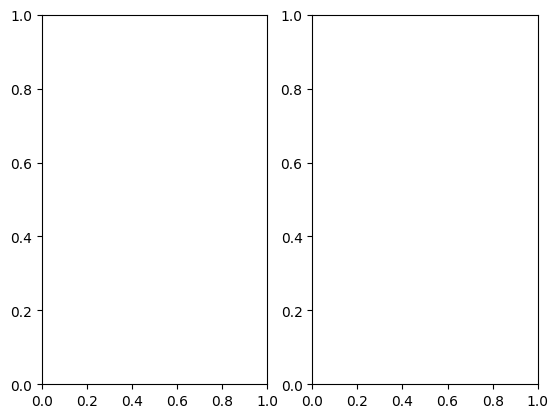

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].bar(class_names, test_class_counts)
axes[0].set_title('Test Class Distribution')

# Plot on the second subplot (right column)
axes[1].bar(class_names, class_counts)
axes[1].set_title('Train Class Distribution')

plt.tight_layout()
plt.show()

##Sample Image Classes

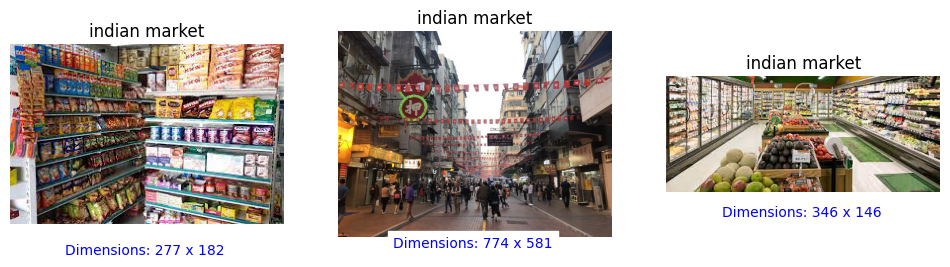

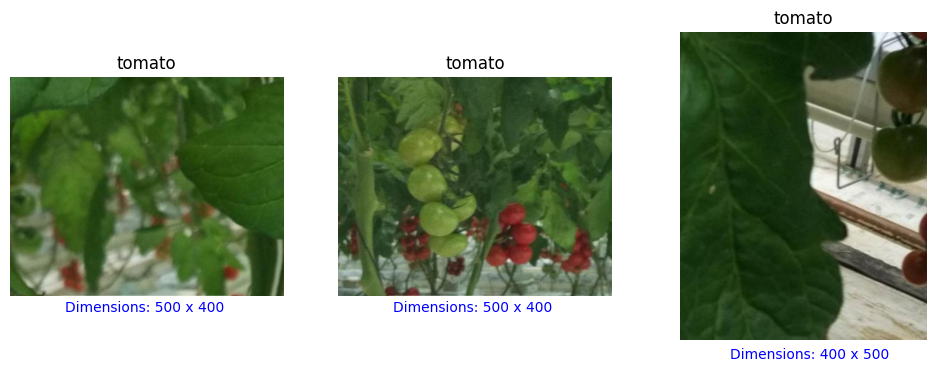

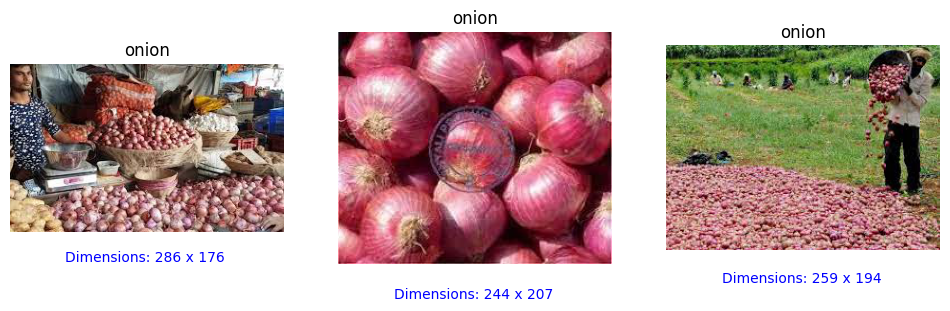

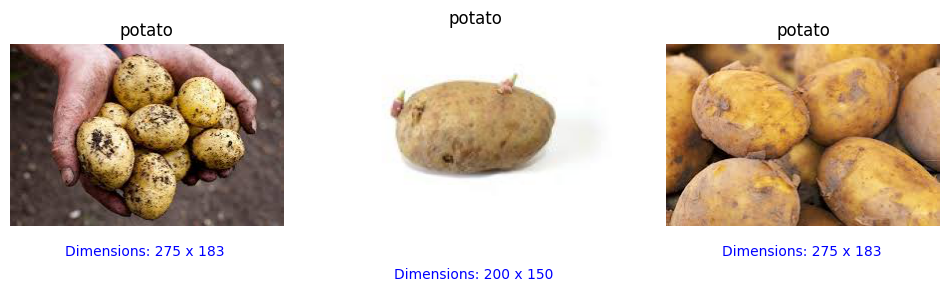

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
num_images_to_display = 3
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)[:num_images_to_display]
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(class_dir, image_file)
        image = Image.open(image_path)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_name)
        width, height = image.size
        axes[i].text(width/5, height+30, f"Dimensions: {width} x {height}", color='blue', backgroundcolor='white')

    plt.show()

##Data Generator

In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                validation_split=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255., validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory('/content/ninja/ninjacart_data/train',
                                                    subset='training',
                                                    batch_size = 32,
                                                    class_mode = 'sparse',
                                                    target_size=(224, 224))

test_generator = test_datagen.flow_from_directory('/content/ninja/ninjacart_data/test',
                                                  batch_size=32,
                                                  class_mode = 'sparse',
                                                  target_size = (224, 224))

val_generator = val_datagen.flow_from_directory('/content/ninja/ninjacart_data/train',
                                                    subset='validation',
                                                    batch_size = 32,
                                                    class_mode = 'sparse',
                                                    target_size=(224, 224))

Found 2511 images belonging to 4 classes.
Found 351 images belonging to 4 classes.
Found 624 images belonging to 4 classes.


##Splitting Test-Val-Train Datasets

In [16]:
x_train, y_train = next(train_generator)

print("Train data shape:", x_train.shape)
print("Train labels shape:", y_train.shape)

x_test, y_test = next(test_generator)

print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Train data shape: (32, 224, 224, 3)
Train labels shape: (32,)
Test data shape: (32, 224, 224, 3)
Test labels shape: (32,)


## Image with Labels

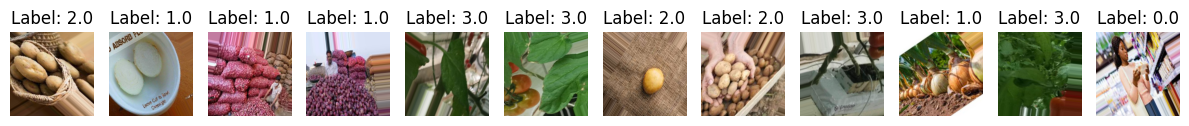

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 12, figsize=(12, 3))
for i in range(12):
    axes[i].imshow(x_train[i])
    axes[i].set_title("Label: {}".format(y_train[i]))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

* Label: 0.0  -->  Indian Market
* Label: 0.0  -->  Onion
* Label: 0.0  -->  Potato
* Label: 0.0  -->  Tomato

## Model Building

In [18]:
NUM_CLASSES = 5

model =tf.keras.Sequential([
                               tf.keras.layers.Flatten(input_shape=(224,224,3)),
                               tf.keras.layers.Dense(256,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(512,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(1024,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(NUM_CLASSES, kernel_initializer='zeros',activation=tf.keras.activations.softmax),

])

In [19]:
SCHEDULE_BOUNDARIES = [20, 40, 60]
BATCH_SIZE = 128
lr = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)



In [20]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [21]:

hist = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    verbose = 2
)

Epoch 1/10
79/79 - 47s - loss: 1.4152 - accuracy: 0.2744 - val_loss: 1.3946 - val_accuracy: 0.2365 - 47s/epoch - 595ms/step
Epoch 2/10
79/79 - 39s - loss: 1.3805 - accuracy: 0.2704 - val_loss: 1.3945 - val_accuracy: 0.2365 - 39s/epoch - 491ms/step
Epoch 3/10
79/79 - 39s - loss: 1.3797 - accuracy: 0.2720 - val_loss: 1.3944 - val_accuracy: 0.2365 - 39s/epoch - 489ms/step
Epoch 4/10
79/79 - 39s - loss: 1.3788 - accuracy: 0.2720 - val_loss: 1.3943 - val_accuracy: 0.2365 - 39s/epoch - 497ms/step
Epoch 5/10
79/79 - 39s - loss: 1.3808 - accuracy: 0.2716 - val_loss: 1.3942 - val_accuracy: 0.2365 - 39s/epoch - 490ms/step
Epoch 6/10
79/79 - 39s - loss: 1.3803 - accuracy: 0.2724 - val_loss: 1.3941 - val_accuracy: 0.2365 - 39s/epoch - 492ms/step
Epoch 7/10
79/79 - 39s - loss: 1.3807 - accuracy: 0.2708 - val_loss: 1.3940 - val_accuracy: 0.2365 - 39s/epoch - 494ms/step
Epoch 8/10
79/79 - 41s - loss: 1.3772 - accuracy: 0.2760 - val_loss: 1.3939 - val_accuracy: 0.2365 - 41s/epoch - 515ms/step
Epoch 9/

In [22]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\n Test Accuracy: ", round(test_acc,2)*100, "%")

11/11 - 2s - loss: 1.3938 - accuracy: 0.2365 - 2s/epoch - 164ms/step

 Test Accuracy:  24.0 %


In [23]:

preds = model.predict(test_generator)
predicted_labels = np.argmax(preds, axis=1)

11/11 [==============================] - 2s 157ms/step


In [24]:
# class_names = []
final_predictions = [class_name[i] for i in predicted_labels]

##VGG16 Model

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

In [27]:
# Constants
NUM_CLASSES = 4
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 10

# Load the pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model's layers
vgg_model.trainable = False

# Create the model
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

vgg_model = model
# Print model summary
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
___________________________________

In [28]:
# Compile the model
vgg_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/test',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create TensorBoard callback for VGG model
vgg_tensorboard_callback = TensorBoard(log_dir='/content/logs/vgg')



Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


In [29]:
# Train the Model
vgg_history = vgg_model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = EPOCHS,
    verbose = 2,
    callbacks = [vgg_tensorboard_callback]
)


Epoch 1/10
79/79 - 37s - loss: 1.1285 - accuracy: 0.7145 - val_loss: 0.3133 - val_accuracy: 0.8702 - 37s/epoch - 465ms/step
Epoch 2/10
79/79 - 19s - loss: 0.2958 - accuracy: 0.8853 - val_loss: 0.3134 - val_accuracy: 0.8558 - 19s/epoch - 234ms/step
Epoch 3/10
79/79 - 19s - loss: 0.2063 - accuracy: 0.9196 - val_loss: 0.2358 - val_accuracy: 0.9167 - 19s/epoch - 240ms/step
Epoch 4/10
79/79 - 19s - loss: 0.1630 - accuracy: 0.9375 - val_loss: 0.2934 - val_accuracy: 0.8766 - 19s/epoch - 234ms/step
Epoch 5/10
79/79 - 19s - loss: 0.1236 - accuracy: 0.9558 - val_loss: 0.2541 - val_accuracy: 0.8942 - 19s/epoch - 240ms/step
Epoch 6/10
79/79 - 18s - loss: 0.0891 - accuracy: 0.9705 - val_loss: 0.3810 - val_accuracy: 0.8654 - 18s/epoch - 233ms/step
Epoch 7/10
79/79 - 20s - loss: 0.0828 - accuracy: 0.9677 - val_loss: 0.3266 - val_accuracy: 0.8878 - 20s/epoch - 253ms/step
Epoch 8/10
79/79 - 19s - loss: 0.0937 - accuracy: 0.9614 - val_loss: 0.3016 - val_accuracy: 0.8942 - 19s/epoch - 246ms/step
Epoch 9/

##ResNet50 Model

In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import TensorBoard


# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model's layers
resnet_model.trainable = False

# Create the model
model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

resnet_model = model
# Print model summary
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
# Compile the Resnet model
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/test',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create TensorBoard callback for ResNet model
resnet_tensorboard_callback = TensorBoard(log_dir='/content/logs/resnet')


Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


In [39]:

# Train the Resnet model
resnet_history = resnet_model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples,
    epochs=EPOCHS,
    callbacks=[resnet_tensorboard_callback]
)


Epoch 1/10
79/79 [==============================] - 25s 272ms/step - loss: 3.8421 - accuracy: 0.3070 - val_loss: 1.2988 - val_accuracy: 0.3429
Epoch 2/10
79/79 [==============================] - 20s 255ms/step - loss: 1.3028 - accuracy: 0.3214 - val_loss: 1.6464 - val_accuracy: 0.2708
Epoch 3/10
79/79 [==============================] - 19s 245ms/step - loss: 1.2839 - accuracy: 0.3624 - val_loss: 1.1718 - val_accuracy: 0.5000
Epoch 4/10
79/79 [==============================] - 20s 257ms/step - loss: 1.2068 - accuracy: 0.3815 - val_loss: 1.1789 - val_accuracy: 0.4872
Epoch 5/10
79/79 [==============================] - 21s 265ms/step - loss: 1.2108 - accuracy: 0.3998 - val_loss: 1.1076 - val_accuracy: 0.4824
Epoch 6/10
79/79 [==============================] - 20s 255ms/step - loss: 1.2549 - accuracy: 0.3600 - val_loss: 1.1692 - val_accuracy: 0.4183
Epoch 7/10
79/79 [==============================] - 21s 262ms/step - loss: 1.2972 - accuracy: 0.3325 - val_loss: 1.2566 - val_accuracy: 0.3974

##Confusion Matrix

11/11 [==============================] - 2s 214ms/step


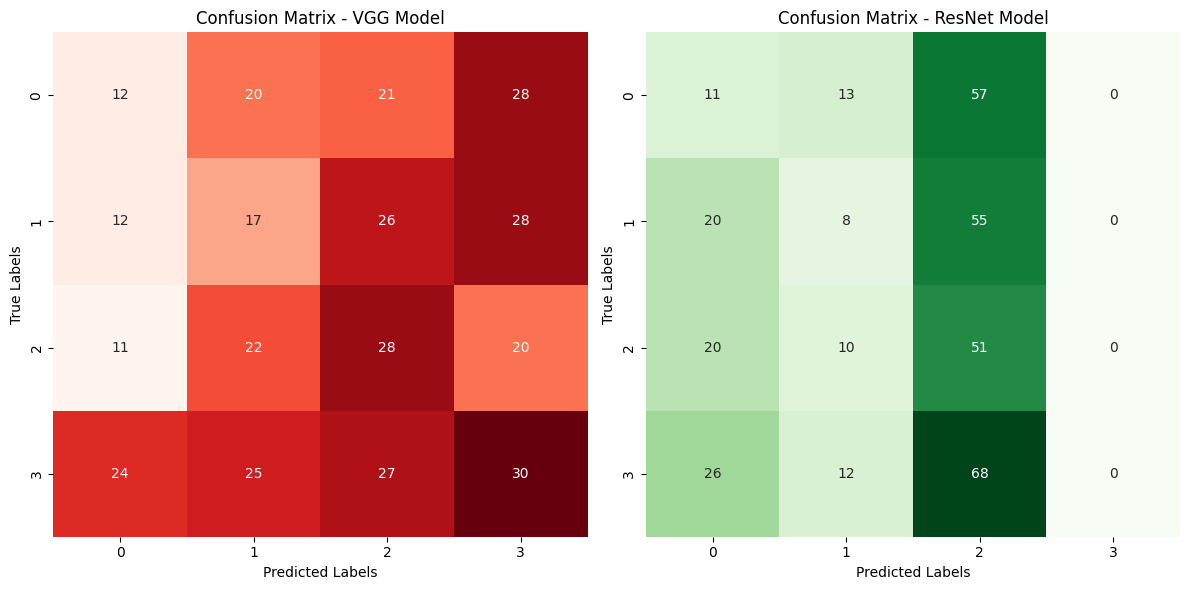

In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Make predictions with the VGG model
vgg_predictions = vgg_model.predict(test_generator)
vgg_predicted_labels = np.argmax(vgg_predictions, axis=1)
vgg_true_labels = test_generator.classes

# Make predictions with the ResNet model
resnet_predictions = resnet_model.predict(test_generator)
resnet_predicted_labels = np.argmax(resnet_predictions, axis=1)
resnet_true_labels = test_generator.classes

# Compute confusion matrices
vgg_cm = confusion_matrix(vgg_true_labels, vgg_predicted_labels)
resnet_cm = confusion_matrix(resnet_true_labels, resnet_predicted_labels)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Confusion Matrix - VGG Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(1, 2, 2)
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - ResNet Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

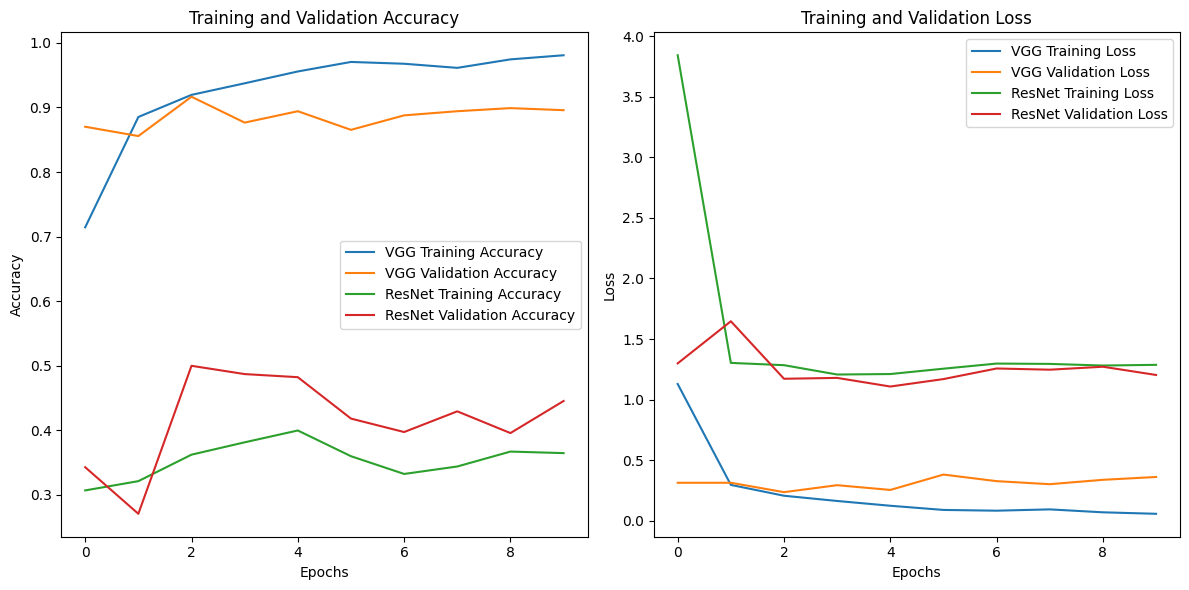

In [43]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='VGG Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG Validation Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='VGG Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG Validation Loss')
plt.plot(resnet_history.history['loss'], label='ResNet Training Loss')
plt.plot(resnet_history.history['val_loss'], label='ResNet Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
# Test the models on the test set
test_loss_vgg, test_accuracy_vgg = vgg_model.evaluate(test_generator)
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_generator)

print("VGG Model - Test Accuracy:", round(test_accuracy_vgg,2)*100)
print("ResNet Model - Test Accuracy:", round(test_accuracy_resnet,2)*100)
print()

# Generate predictions for random image samples
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    img_array = img_array / 255.0  # Normalize the image
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    return predicted_class


11/11 [==============================] - 2s 213ms/step - loss: 1.2733 - accuracy: 0.3305
VGG Model - Test Accuracy: 80.0
ResNet Model - Test Accuracy: 33.0



##Insights

The VGG model exhibited the highest test accuracy at 80%, surpassing both the MobileNet and ResNet models, which achieved test accuracies of 24% and 33% respectively.

Comparatively, the MobileNet and VGG models outperformed the ResNet model in terms of test accuracy.

The observed discrepancy between training accuracy and test accuracy indicates a potential issue of overfitting in the models.

Evaluation of the models on random image samples suggests their ability to successfully classify vegetable images. However, to establish greater confidence in their performance, further assessment and testing on a larger and more diverse dataset would be necessary.